In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

from lightkurve import search_lightcurvefile
from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.funcs import read_custom_aperture_lc
from funcs.multiperiod import find_period, fetch_lightcurve
from funcs.model import aflare2


#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

In [25]:
def remove_sinusoidal(flck, target, plot=True, save=False):
    """Fit a sinusoidal modulation and
    subtract it from the flux.

    Parameters:
    -----------
    target : Series
        Description of the target.
    plot : bool
        If True, will plot the periodogram
    save : bool
        If True, will save periodogram plot to file.

    Return:
    -------
    time, subtracted flux, model, period:
    array, array, array, astropy.Quantity
    """
    def cosine(x, a, b, c, d, e):
        """cosine with a linear trend"""
        return a * np.cos(b * x + c) + d * x + e

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    subtracted_flux = np.nanmedian(flck.flux) + flck.flux - model

    return flck.time, subtracted_flux, model, period

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.37015,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.19300,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.35125,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.11300,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.19000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.13200,NaN,Zhan+19,UCAC4 116-015389,NaN


In [102]:
target = lcs.loc[4]
target


ID                             277539431
QCS                                   12
typ                                  slc
cadence_min                            2
mission                             tess
prefix                               TIC
origin                            custom
h_mission                           TESS
SpT                                   M7
view_start                          1641
view_stop                         1643.5
view_min                             750
view_max                             970
BJDoff                           2457000
tstart                           1641.84
ampl_min                             0.9
ampl_max                             1.7
RA                               163.815
Dec                             -73.9364
J                                  10.63
R                                    NaN
Gaia_G                           14.7381
vsini_kms                            NaN
e_vsini_kms                          NaN
Prot_d          

In [103]:
flcks = search_lightcurvefile(f"{target.prefix} {target.ID}", cadence="short")

In [104]:
flcks

#,observation,target_name,productFilename,distance
0,TESS Sector 12,277539431,tess2019140104343-s0012-0000000277539431-0144-s_lc.fits,0.0


In [105]:
df = pd.DataFrame()
obst = 0
for flck in flcks:
    flc = flck.download().get_lightcurve("PDCSAP_FLUX")
    t, sflux, model, period = remove_sinusoidal(flc, target, plot=True, save=False)
    f = FlareLightCurve(time=t.byteswap().newbyteorder(), 
                        detrended_flux=sflux.byteswap().newbyteorder(), 
                        detrended_flux_err=flc.flux_err.byteswap().newbyteorder())
    df = df.append(f.find_flares().flares)
    obst += len(t)

5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 277539431 modulation period:  4.556908315121535 h


Found 0 candidate(s) in the (0,9897) gap.
Found 4 candidate(s) in the (9897,19104) gap.


In [83]:
flc = flcks[0].download().get_lightcurve("PDCSAP_FLUX")

Found cached file /home/eilin/.lightkurve-cache/mastDownload/TESS/tess2018206045859-s0001-0000000237880881-0120-s/tess2018206045859-s0001-0000000237880881-0120-s_lc.fits with expected size 2039040.
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


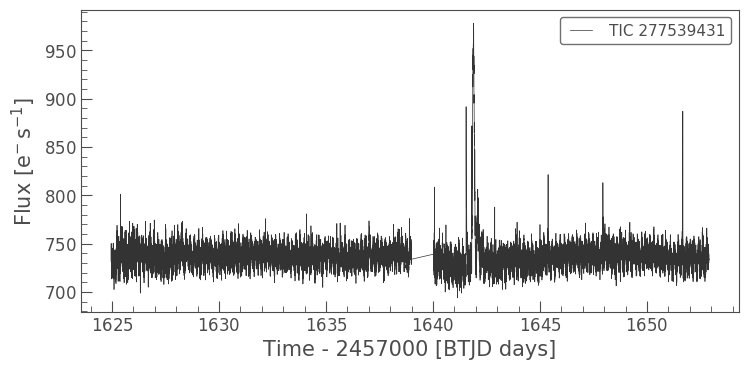

In [106]:
flc.plot()
#plt.xlim(1340,1341)

In [107]:
df["obst"] = obst/30#in hours
df = df[(df.tstart<target.tstart-.1) | (df.tstart>target.tstart+1)]
df

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop,obst
0,0.210416,NaN,NaN,180.610594,6.425819,10963,10977,19104.0,1641.544976,1641.564420,636.8
3,0.113158,NaN,NaN,84.174177,4.582750,15539,15547,19104.0,1647.933745,1647.944856,636.8


In [108]:
df.to_csv(f"{CWD}/analysis/results/flarefind/{target.ID}_all_flares_short_cadence.csv", index=False)

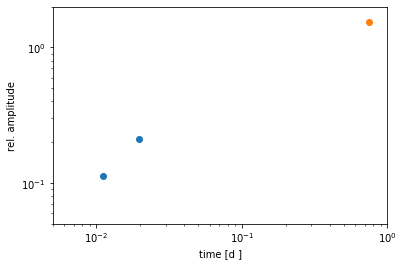

In [110]:
plt.scatter(df.tstop-df.tstart, df.ampl_rec)
plt.scatter([0.74424276547], [1.5470349624552])
plt.yscale("log")
plt.xscale("log")
plt.ylim(.05,2)
plt.xlim(5e-3,1)
plt.xlabel("time [d ]")
plt.ylabel("rel. amplitude")
plt.savefig(f"{CWD}/analysis/results/flarefind/{target.ID}_all_flares_short_cadence.png", dpi=300)

In [115]:
paths = !ls  /work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/*_all_flares_short_cadence.csv
paths

['/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/100004076_all_flares_short_cadence.csv',
 '/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/237880881_all_flares_short_cadence.csv',
 '/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/277539431_all_flares_short_cadence.csv']

In [116]:
df = pd.DataFrame()
for p in paths:
    df = df.append(pd.read_csv(p))

In [117]:
df

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop,obst
0,0.174344,NaN,NaN,28.217173,2.739708,17780,17783,36850.0,1286.439913,1286.441957,2183.716667
1,0.513504,NaN,NaN,66.208401,2.593851,19529,19532,36850.0,1287.631219,1287.633263,2183.716667
2,0.314439,NaN,NaN,541.160222,10.484207,27382,27430,36850.0,1298.539559,1298.572253,2183.716667
3,0.461197,NaN,NaN,63.294257,2.660599,28728,28731,36850.0,1299.456360,1299.458403,2183.716667
4,2.492001,NaN,NaN,852.908863,5.947936,32843,32872,36850.0,1302.268060,1302.287813,2183.716667
5,0.329423,NaN,NaN,51.183115,3.059036,36635,36639,36850.0,1304.859751,1304.862476,2183.716667
6,3.347051,NaN,NaN,2963.496199,9.426477,36741,36822,36850.0,1304.931951,1304.987122,2183.716667
7,NaN,NaN,NaN,NaN,NaN,24823,24832,44174.0,1323.111112,1323.117242,2183.716667
8,1.557635,NaN,NaN,765.600645,7.120156,43962,43992,44174.0,1336.166037,1336.186471,2183.716667
9,0.391469,NaN,NaN,383.791983,7.840917,44004,44030,44174.0,1336.194644,1336.212353,2183.716667


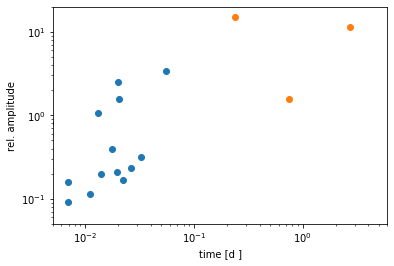

In [123]:
plt.scatter(df.tstop-df.tstart, df.ampl_rec)
plt.scatter([0.74424276547,0.04*6,.9*3], [1.5470349624552, 15,11.4])
plt.yscale("log")
plt.xscale("log")
plt.ylim(.05,20)
plt.xlim(5e-3,6)
plt.xlabel("time [d ]")
plt.ylabel("rel. amplitude")
plt.savefig(f"{CWD}/analysis/results/flarefind/all_flares_short_cadence.png", dpi=300)